In [1]:
import os
import pandas as pd
import numpy as np
import sklearn.ensemble
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

%matplotlib inline
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

hp = pd.read_csv("./data/HousePrice2.csv", index_col = 0)
hp_res= hp[hp['MSZoning'].isin(['FV','RH','RL','RM'])]
hp_res = hp_res.dropna()
hp_res.shape

Current working directory: /Users/chereowang27/NYCDSA/Machine_Learning_I/Machine_Learning_Project/Ames_Housing_ML


(2530, 83)

In [2]:
hp_res['price_cat'] = pd.qcut(hp_res['SalePrice'], labels = [1,2,3,4,5,6,7,8,9,10], q = 10)
pr_dict = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:1} 
hp_res['price_cat'] = hp_res['price_cat'].map(pr_dict, 1)

hp_res['bath'] = hp_res['FullBath'] + 0.5*hp_res['HalfBath']

In [3]:
def label_nb(row):
    if row['Neighborhood'] in (['NridgHt','NoRidge','Veenker','StoneBr']):      
        return 'N'
    if row['Neighborhood']      \
             in (['Blmngtn','Gilbert','OldTown', 'NWAmes','NAmes','Blmngtn','BrDale','Somerst','BrkSide','Greens','NPkVill']):
        return 'NE'
    if row['Neighborhood']      \
            in (['CollgCr','SWISU', 'Edwards','SawyerW','Sawyer','ClearCr']):
        return 'W'                      
    if row['Neighborhood'] in (['Crawfor','MeadowV','Timber','Mitchel','IDOTRR']):     
        return 'S'
    
hp_res['Location']=hp_res.apply(lambda row: label_nb(row), axis = 1)
hp_res.columns

Index(['address', 'latitude', 'longitude', 'MapRefNo', 'Prop_Addr',
       'Unnamed: 0.1', 'PID', 'GrLivArea', 'SalePrice', 'MSSubClass',
       'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', '

In [4]:
hp_res = hp_res.drop(['Neighborhood','address', 'latitude', 'longitude', 'MapRefNo', 'Prop_Addr',\
       'Unnamed: 0.1',
                  'FullBath', 'HalfBath', \
                  'BsmtFullBath', 'BsmtHalfBath', \
                  'BsmtFinSF1','ExterQual', \
                  'Condition1','Condition2', \
                  'BsmtFinType1','BsmtFinType2', \
                  'BsmtQual', 'GarageQual','MoSold',   \
                  'BsmtFinSF2', 'BsmtUnfSF'], axis = 1)

catCol = ['MSSubClass', 'MSZoning','Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'BldgType', 'HouseStyle','OverallCond','RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterCond', 'Foundation',
       'BsmtCond', 'BsmtExposure', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish','GarageCond', 'PavedDrive',
       'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal','SaleType',
       'SaleCondition','Location']


In [5]:
y_reg = hp_res['SalePrice']
features_reg = hp_res.drop(['price_cat','SalePrice','PID'],axis = 1)
features_reg = pd.get_dummies(features_reg, columns = catCol, drop_first = True)

In [6]:
features_reg.columns

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       ...
       'SaleType_VWD', 'SaleType_WD ', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'Location_NE', 'Location_S', 'Location_W'],
      dtype='object', length=539)

In [7]:
hp_res.groupby(['price_cat']).count()['PID']

price_cat
0    2277
1     253
Name: PID, dtype: int64

In [7]:
# Upsampling for GB classifier model
from sklearn.utils import resample
minorIndex = hp_res[hp_res['price_cat']==1].PID.values
resampled = resample(minorIndex, n_samples = 2277-253)
LEFT = pd.DataFrame(list(hp_res.PID) + list(resampled), columns = ['INDEX'])
hp_res_upsampled = pd.merge(LEFT, hp_res, how = 'left', left_on = 'INDEX', right_on = 'PID')


In [8]:
y_class = hp_res_upsampled['price_cat']
features_class = hp_res.drop(['price_cat', 'SalePrice', 'PID'], axis = 1)
features_class = pd.get_dummies(features_class, columns = catCol, drop_first = True)
                  

In [9]:
#GBM regressor 
X_reg = features_reg
gbm = GradientBoostingRegressor()
gbm.set_params(verbose = 1)
gbm.fit(X_reg, y_reg)

      Iter       Train Loss   Remaining Time 
         1  4805509708.4692            2.65s
         2  4142224048.4514            2.26s
         3  3600355255.3338            2.01s
         4  3145285514.1312            1.82s
         5  2769074537.8111            1.69s
         6  2442167246.2761            1.60s
         7  2171129860.8546            1.53s
         8  1945577246.9844            1.47s
         9  1737671390.7420            1.43s
        10  1554890431.7340            1.38s
        20   702549297.1295            1.14s
        30   471982216.8676            0.96s
        40   383053760.5246            0.82s
        50   339166920.6450            0.68s
        60   310747729.7598            0.54s
        70   288605380.2518            0.40s
        80   273097971.6196            0.27s
        90   259224031.7559            0.14s
       100   246142037.8198            0.00s


GradientBoostingRegressor(verbose=1)

In [143]:
X_reg.shape

(2530, 539)

In [144]:
y_reg.shape

(2530,)

In [145]:
import time

from sklearn.model_selection import GridSearchCV
#params = {'learning_rate':[.0001,.001,.01, .1, 1] , 'max_depth':[4]} #{'learning_rate': 0.08893939393939393, 'max_depth': 4}

#params1 = {'learning_rate':np.linspace(0.08,.1,10) , 'max_depth':[4]} #{'learning_rate': 0.08888888888888889, 'max_depth': 4}

params2 = {'learning_rate':np.linspace(0.088,0.089, 100) , 'max_depth':[4]} #{'learning_rate': 0.08887878787878788, 'max_depth': 4}
gs_gbm = GridSearchCV(GradientBoostingRegressor(),param_grid = params2, cv = 3 )

start= time.time()
gs_gbm.fit(X_reg,y_reg)
print(time.time() - start)
print(gs_gbm.best_params_)

335.7793769836426
{'learning_rate': 0.0882020202020202, 'max_depth': 4}


In [11]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train_reg, X_test_reg, Y_train_reg, \
Y_test_reg = train_test_split(X_reg, y_reg, test_size = 0.3, random_state = 0)

learning_rate = 0.0882
max_depth = 4
gbm = GradientBoostingRegressor(
    learning_rate = learning_rate, n_estimators = 10000, max_depth = 4)
gbm.fit(X_train_reg, Y_train_reg)

GradientBoostingRegressor(learning_rate=0.0882, max_depth=4, n_estimators=10000)

In [13]:
mse = mean_squared_error(Y_test_reg, gbm.predict(X_test_reg))
mse


498812141.8443373

In [127]:
X_train_reg.columns

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF',
       ...
       'SaleType_VWD', 'SaleType_WD ', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'Location_NE', 'Location_S', 'Location_W'],
      dtype='object', length=192)

In [14]:
sorted_importances = sorted(zip(X_train_reg.columns, gbm.feature_importances_),
                             key = lambda t:t[1], reverse = True)
sorted_importances20 = sorted_importances[:20]
sorted_importances

[('OverallQual', 0.5221778031250773),
 ('GrLivArea', 0.14839579483582777),
 ('TotalBsmtSF', 0.05548427357057093),
 ('1stFlrSF', 0.052777290708979865),
 ('GarageCars', 0.029576472153308452),
 ('GarageArea', 0.023507844580111088),
 ('YearBuilt', 0.01983054801445501),
 ('LotArea', 0.017586022558422915),
 ('bath', 0.013335657823514499),
 ('Fireplaces', 0.01260001650904316),
 ('YearRemodAdd', 0.011196296707173627),
 ('GarageYrBlt', 0.00691270535205853),
 ('MasVnrArea', 0.0067214052838779625),
 ('BsmtExposure_Gd', 0.005679480788162524),
 ('KitchenQual_Gd', 0.005156670487220054),
 ('MSZoning_RM', 0.004759415442541182),
 ('FireplaceQu_No Fireplace', 0.00414205847217338),
 ('LotFrontage', 0.003931919614183136),
 ('2ndFlrSF', 0.0038629660027744285),
 ('WoodDeckSF', 0.003217525974607553),
 ('KitchenQual_TA', 0.0030592269364477396),
 ('MasVnrType_Stone', 0.0025974180208250723),
 ('OpenPorchSF', 0.0016998155997639903),
 ('BsmtExposure_No', 0.0015958241390755877),
 ('CentralAir_Y', 0.001547440371396

<AxesSubplot:ylabel='feature_name'>

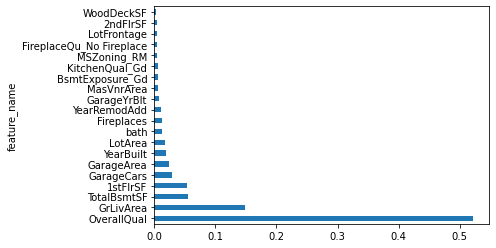

In [15]:
a,b = zip(*sorted_importances20)
pd.DataFrame({'feature_name':a, 'importance_score':b})   \
            .plot.barh(x = 'feature_name', y = 'importance_score', legend = None)


In [138]:
from copy import deepcopy

gbm_models = []
warm_start = False
steps = list(range(1,501,50))
for n_estimators in steps: 
    gbm.set_params(n_estimators = n_estimators, learning_rate = learning_rate, warm_start = warm_start)
    gbm_models.append(deepcopy(gbm.fit(X_train_log, Y_train_log)))
    warm_start = True

In [141]:
gbm_importances = pd.DataFrame([model.feature_importances_ for model in gbm_models],  \
            index = steps, columns = X_train_log.columns)

Text(0, 0.5, 'feature importance')

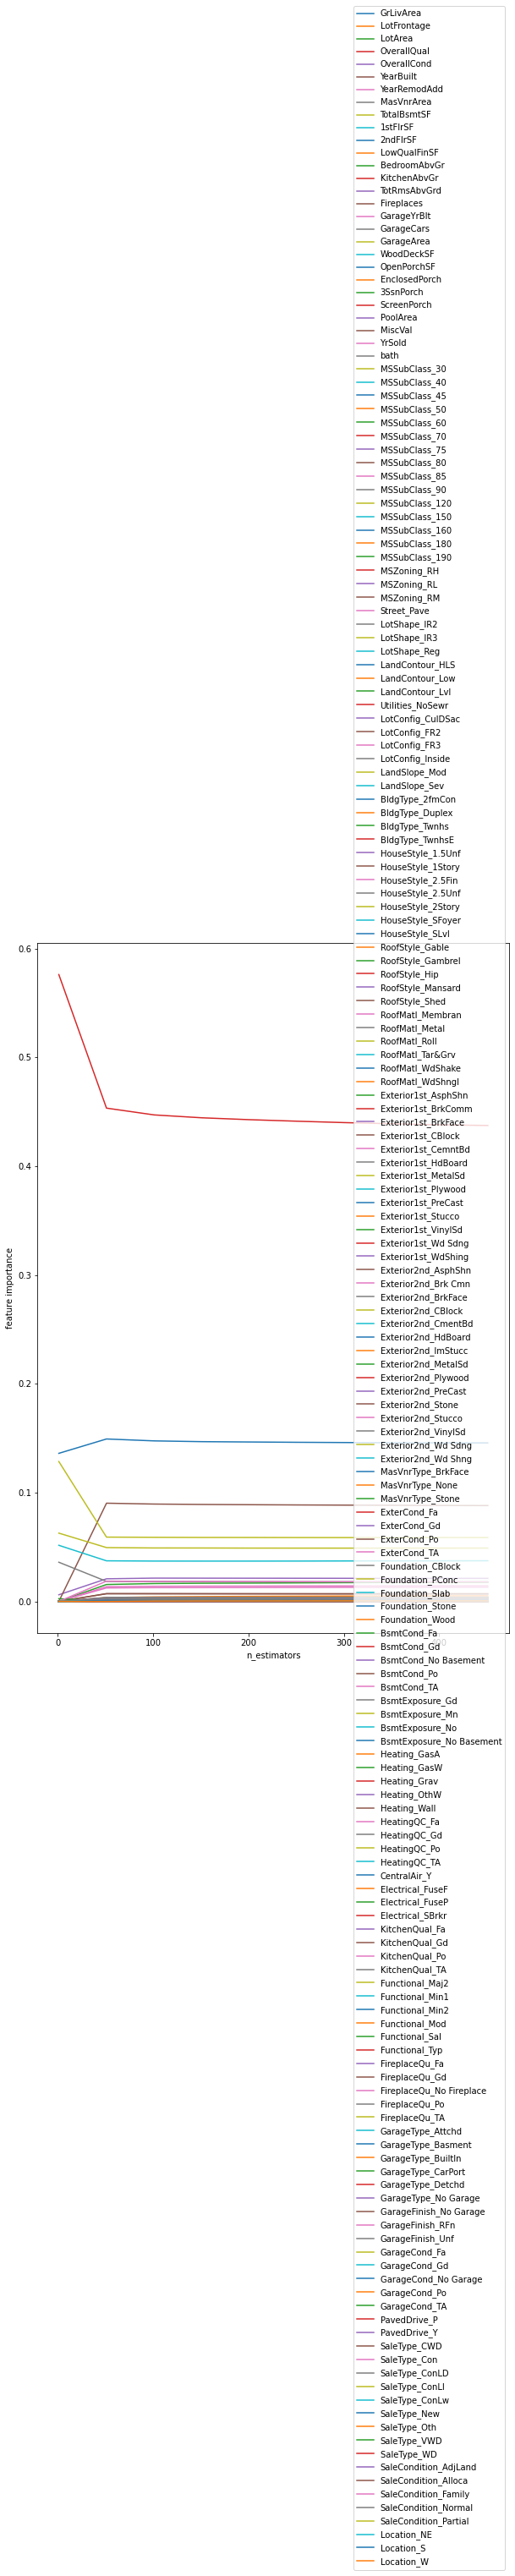

In [148]:
plt.rcParams['figure.figsize'] = (10,15)
for feature in gbm_importances.columns: 
    plt.plot(gbm_importances.index, gbm_importances[feature], label = feature)
plt.legend(loc = 5)
plt.xlabel('n_estimators')
plt.ylabel('feature importance')

In [16]:
#GBM classifier multiclass

# Upsampling for GB classifier model
from sklearn.utils import resample
minorIndex = hp_res[hp_res['price_cat']==1].PID.values
resampled = resample(minorIndex, n_samples = 2277-253)
LEFT = pd.DataFrame(list(hp_res.PID) + list(resampled), columns = ['INDEX'])
hp_res_upsampled = pd.merge(LEFT, hp_res, how = 'left', left_on = 'INDEX', right_on = 'PID')

y_class = hp_res_upsampled['price_cat']
features_class = hp_res_upsampled.drop(['price_cat', 'SalePrice', 'PID'], axis = 1)
X_class = pd.get_dummies(features_class, columns = catCol, drop_first = True)   \
        .drop(['INDEX'],axis = 1)
X_class.columns

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       ...
       'SaleType_VWD', 'SaleType_WD ', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'Location_NE', 'Location_S', 'Location_W'],
      dtype='object', length=539)

In [18]:
features_class[catCol].columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle',
       'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'PavedDrive',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'SaleType',
       'SaleCondition', 'Location'],
      dtype='object')

In [19]:
cols = features_class.select_dtypes([np.number]).columns
cols

Index(['INDEX', 'GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'bath'],
      dtype='object')

In [185]:
X_class.shape

(4712, 539)

In [186]:
y_class.shape

(4712,)

In [158]:
X_class = features_class 


In [20]:

from sklearn.model_selection import train_test_split, GridSearchCV
X_train_class, X_test_class, Y_train_class, \
Y_test_class = train_test_split(X_class, y_class, test_size = 0.3, random_state = 0)

In [28]:
import time
from sklearn.ensemble import GradientBoostingClassifier
# params = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1,1,10,100], 
#           'max_depth':[4]} 
params = {'learning_rate':[1.5],
          'max_depth': np.linspace(10,100,1) }     #1
gbm_c = GradientBoostingClassifier()
gs_gbm_c = GridSearchCV(gbm_c, param_grid = params, cv = 3)

start= time.time()
gs_gbm_c.fit(X_train_class,Y_train_class)
print(time.time() - start)
print(gs_gbm_c.best_params_)


13.697424173355103
{'learning_rate': 1.5, 'max_depth': 10.0}


In [29]:
gbm_c.set_params(learning_rate = 1.5, n_estimators = 3000, max_depth=10, 
                 subsample = 0.3, verbose = 0)
gbm_c.fit(X_train_class, Y_train_class)
print('Training Accuracy %.2f' %gbm_c.score(X_train_class, Y_train_class))
print('Testing Accuracy %.2f' %(gbm_c.score(X_test_class, Y_test_class)))

Training Accuracy 0.99
Testing Accuracy 0.99


In [30]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_train_class, gbm_c.predict(X_train_class)))

[[1648    7]
 [  25 1614]]


In [31]:
print(confusion_matrix(Y_test_class, gbm_c.predict(X_test_class)))

[[692  12]
 [  8 701]]


In [34]:
print("Train Score: ", gbm_c.score(X_train_class, Y_train_class))
print("Test Score: ", gbm_c.score(X_test_class, Y_test_class))

Train Score:  0.9902853673345476
Test Score:  0.9858457183297947
